In [1]:
import tkinter as tk
from tkinter import filedialog
import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to parse the input file and extract vehicle capacity and customer data
def parse_input(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize variables
    vehicle_capacity = None
    customers = []

    # Extract vehicle capacity by looking for the "CAPACITY" line
    for i, line in enumerate(lines):
        if "CAPACITY" in line:
            # Get the next line for the actual values
            values_line = lines[i + 1].strip().split()
            vehicle_capacity = int(values_line[1])  # Extract the capacity value
            break

    if vehicle_capacity is None:
        raise ValueError("Vehicle capacity not found in the input file.")

    # Locate the start of the customer data
    start_index = None
    for i, line in enumerate(lines):
        if "CUST NO." in line:
            start_index = i + 1  # Data starts immediately after this line
            break

    if start_index is None:
        raise ValueError("Customer data section not found in file.")

    # Parse customer data
    for line in lines[start_index:]:
        data = line.strip().split()
        if len(data) < 7:  # Ignore lines without sufficient data
            continue
        try:
            customer = {
                "id": int(data[0]),
                "x": float(data[1]),
                "y": float(data[2]),
                "demand": int(data[3]),
                "ready_time": int(data[4]),
                "due_date": int(data[5]),
                "service_time": int(data[6])
            }
            customers.append(customer)
        except ValueError:
            # Skip malformed lines
            continue

    return vehicle_capacity, customers

In [3]:
# Function to calculate Euclidean distance between two customers
def euclidean_distance(cust1, cust2):
    return math.sqrt((cust1['x'] - cust2['x'])**2 + (cust1['y'] - cust2['y'])**2)


# Function to calculate travel time (using Euclidean distance as a proxy for time)
def calculate_travel_time(cust1, cust2):
    return euclidean_distance(cust1, cust2)

In [4]:
# Genetic Algorithm helpers
def generate_initial_population(population_size, num_customers):
    population = []
    for _ in range(population_size):
        individual = list(range(num_customers))
        random.shuffle(individual)
        population.append(individual)
    return population

In [5]:
# Function to calculate the depot's position as the center of the customer locations
def calculate_depot_center(customers):
    x_center = sum(cust['x'] for cust in customers) / len(customers)
    y_center = sum(cust['y'] for cust in customers) / len(customers)
    return x_center, y_center

In [6]:
def mutate(individual, mutation_rate):
    if random.random() < mutation_rate:
        # Randomly choose two positions to swap
        pos1, pos2 = random.sample(range(len(individual)), 2)
        individual[pos1], individual[pos2] = individual[pos2], individual[pos1]
    return individual

In [7]:
def fitness(individual, dist_matrix, vehicle_capacity, customers):
    total_distance = 0
    total_demand = 0
    num_vehicles = 1  # Start with one vehicle
    
    for i in range(len(individual) - 1):
        current_customer = customers[individual[i]]
        next_customer = customers[individual[i + 1]]
        
        total_distance += dist_matrix[individual[i]][individual[i + 1]]
        total_demand += current_customer['demand']
        
        # Check if we exceed the vehicle's capacity
        if total_demand > vehicle_capacity:
            num_vehicles += 1
            total_demand = next_customer['demand']  # Start with the next customer's demand
            
    return total_distance  # You can modify to add penalty based on vehicles used




def crossover(parent1, parent2):
    # Perform crossover between two parents (partially mapped crossover)
    size = len(parent1)
    child = [-1] * size
    crossover_point = random.randint(0, size)

    # Copy part of the first parent to the child
    for i in range(crossover_point):
        child[i] = parent1[i]

    # Fill the remaining part with genes from the second parent
    for i in range(size):
        if child[i] == -1:
            for gene in parent2:
                if gene not in child:
                    child[i] = gene
                    break
    return child


In [8]:
def select_parents(population, dist_matrix, vehicle_capacity, customers):
    # Tournament selection: select the best two individuals
    tournament_size = 5
    selected = random.sample(population, tournament_size)
    selected.sort(key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
    return selected[0], selected[1]

In [9]:
# Plotting functions
def plot_routes(customers, routes, depot=(0, 0)):
    plt.figure(figsize=(12, 8))
    plt.plot(depot[0], depot[1], 'ks', label="Depot", markersize=10)
    plt.text(depot[0] + 0.2, depot[1], 'Depot', fontsize=12, ha='left')

    customer_x = [cust['x'] for cust in customers]
    customer_y = [cust['y'] for cust in customers]
    plt.scatter(customer_x, customer_y, c='b', label="Customers", zorder=5)

    for cust in customers:
        plt.text(cust['x'] + 0.2, cust['y'], str(cust['id']), fontsize=9, ha='right')

    for route_idx, route in enumerate(routes):
        route_x = [customers[customer_id]['x'] for customer_id in route]
        route_y = [customers[customer_id]['y'] for customer_id in route]
        route_x = [depot[0]] + route_x + [depot[0]]
        route_y = [depot[1]] + route_y + [depot[1]]
        plt.plot(route_x, route_y, marker='o', linestyle='-', label=f"Route {route_idx + 1}")

    plt.title('Vehicle Routing Problem (VRP) - All Routes', fontsize=16)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_individual_routes(customers, routes, depot=(0, 0)):
    for route_idx, route in enumerate(routes):
        plt.figure(figsize=(8, 6))
        plt.plot(depot[0], depot[1], 'ks', label="Depot", markersize=10)
        plt.text(depot[0] + 0.2, depot[1], 'Depot', fontsize=12, ha='left')

        route_x = [customers[customer_id]['x'] for customer_id in route]
        route_y = [customers[customer_id]['y'] for customer_id in route]
        route_x = [depot[0]] + route_x + [depot[0]]
        route_y = [depot[1]] + route_y + [depot[1]]
        plt.plot(route_x, route_y, marker='o', linestyle='-', label=f"Route {route_idx + 1}")
        plt.scatter([customers[customer_id]['x'] for customer_id in route],
                    [customers[customer_id]['y'] for customer_id in route],
                    c='b', label="Customers")

        for customer_id in route:
            cust = customers[customer_id]
            plt.text(cust['x'] + 0.2, cust['y'], str(cust['id']), fontsize=9, ha='right')

        plt.title(f'Route {route_idx + 1}', fontsize=16)
        plt.xlabel('X Coordinate', fontsize=12)
        plt.ylabel('Y Coordinate', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()

def plot_fitness_evolution(fitness_values):
    plt.figure(figsize=(8, 6))
    plt.plot(fitness_values, color='b', marker='o')
    plt.title('Fitness Evolution Over Generations', fontsize=16)
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Fitness Value (Total Distance)', fontsize=12)
    plt.grid(True)
    plt.show()

In [10]:
# Extract routes
def extract_routes(best_individual, customers, vehicle_capacity):
    routes = []
    total_demand = 0
    routes.append([best_individual[0]])

    for i in range(1, len(best_individual)):
        current_customer = customers[best_individual[i - 1]]
        next_customer = customers[best_individual[i]]
        total_demand += current_customer['demand']

        if total_demand > vehicle_capacity:
            routes.append([best_individual[i]])
            total_demand = next_customer['demand']
        else:
            routes[-1].append(best_individual[i])

    return routes

In [11]:
# # Replace the fixed depot coordinates with the calculated center
# def solve_vrptw_with_centered_depot(file_path):
#     vehicle_capacity, customers = parse_input(file_path)
#     num_customers = len(customers)

#     # Calculate the depot location as the center of customers
#     depot_x, depot_y = calculate_depot_center(customers)
#     depot = (depot_x, depot_y)

#     dist_matrix = np.zeros((num_customers, num_customers))
#     for i in range(num_customers):
#         for j in range(num_customers):
#             dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

#     population_size = 50
#     generations = 100
#     mutation_rate = 0.01
#     population = generate_initial_population(population_size, num_customers)
    
#     fitness_history = []
#     evolved_vehicles_count = []
    

#     for gen in range(generations):
#         new_population = []
#         for _ in range(population_size // 2):
#             parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
#             child1 = crossover(parent1, parent2)
#             child2 = crossover(parent2, parent1)
#             new_population.append(mutate(child1, mutation_rate))
#             new_population.append(mutate(child2, mutation_rate))
#         population = new_population

#         best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
#         fitness_history.append(fitness(best_individual, dist_matrix, vehicle_capacity, customers))
#         routes = extract_routes(best_individual, customers, vehicle_capacity)
#         num_vehicles = len(routes)
#         evolved_vehicles_count.append(num_vehicles)
#         print(f"Generation {gen + 1}, Best Fitness: {fitness_history[-1]}")

#     best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
#     routes = extract_routes(best_individual, customers, vehicle_capacity)

#     # Plot the results with the depot in the center
#     plot_fitness_evolution(fitness_history)  # Fitness evolution over generations
#     plot_routes(customers, routes, depot=depot)
#     plot_individual_routes(customers, routes, depot=depot)



In [12]:
def check_constraints(routes, customers, vehicle_capacity):
    """
    - Vehicle capacity constraint.
    - Time window constraint.
    - All customers visited constraint.
    """
    all_customers_met = True
    violated_constraints = []

    # Track which customers are visited
    visited_customers = set()

    for route_idx, route in enumerate(routes):
        total_demand = 0
        current_time = 0

        for customer_id in route:
            customer = customers[customer_id]
            visited_customers.add(customer_id)

            # Vehicle capacity constraint
            total_demand += customer['demand']
            if total_demand > vehicle_capacity:
                violated_constraints.append(f"Route {route_idx + 1}: Vehicle capacity exceeded.")
                break

            # Time window constraint
            if current_time < customer['ready_time']:
                current_time = customer['ready_time']  # Wait for time window
            elif current_time > customer['due_date']:
                violated_constraints.append(f"Route {route_idx + 1}: Customer {customer['id']} missed time window.")
                break

            # Add service time and travel time to the next customer
            current_time += customer['service_time']

        # Ensure the vehicle returns to the depot within constraints
        depot_return_time = current_time  # (Modify if the depot has time constraints)
        if depot_return_time > 24 * 60:  # Example: 24-hour constraint
            violated_constraints.append(f"Route {route_idx + 1}: Depot return time violated.")

    # Check if all customers are visited
    missed_customers = set(range(len(customers))) - visited_customers
    if missed_customers:
        all_customers_met = False
        violated_constraints.append(f"Missed customers: {missed_customers}")

    return all_customers_met, violated_constraints


In [13]:
def evaluate_solution(file_path):
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    # Calculate depot location as the center of customers
    depot_x, depot_y = calculate_depot_center(customers)
    depot = (depot_x, depot_y)

    # Create distance matrix
    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    population_size = 50
    generations = 100
    mutation_rate = 0.01
    population = generate_initial_population(population_size, num_customers)

    for gen in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))
        population = new_population

    best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
    routes = extract_routes(best_individual, customers, vehicle_capacity)

    # Check constraints
    all_met, violations = check_constraints(routes, customers, vehicle_capacity)

    # Output results
    print(f"File: {file_path}")
    print(f"Best Fitness: {fitness(best_individual, dist_matrix, vehicle_capacity, customers)}")
    print(f"Total Routes: {len(routes)}")
    if all_met:
        print("All constraints satisfied.")
    else:
        print("Constraints violated:")
        for violation in violations:
            print(f"  - {violation}")


In [14]:

def evaluate_parameter_combinations(file_path):
    # Parse input file and calculate depot location
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    # Calculate depot location as the center of customer locations
    depot_x, depot_y = calculate_depot_center(customers)
    depot = (depot_x, depot_y)

    # Create distance matrix
    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    # Parameter combinations
    population_sizes = [20, 50, 100]
    generations_list = [50, 100, 200]
    mutation_rates = [0.01, 0.05, 0.1]

    best_combination = None
    best_fitness = float('inf')
    results = []

    # Evaluate all combinations
    for population_size in population_sizes:
        for generations in generations_list:
            for mutation_rate in mutation_rates:
                population = generate_initial_population(population_size, num_customers)

                for gen in range(generations):
                    new_population = []
                    for _ in range(population_size // 2):
                        parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
                        child1 = crossover(parent1, parent2)
                        child2 = crossover(parent2, parent1)
                        new_population.append(mutate(child1, mutation_rate))
                        new_population.append(mutate(child2, mutation_rate))
                    population = new_population

                best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
                best_individual_fitness = fitness(best_individual, dist_matrix, vehicle_capacity, customers)

                # Record the results
                results.append({
                    'population_size': population_size,
                    'generations': generations,
                    'mutation_rate': mutation_rate,
                    'fitness': best_individual_fitness
                })

                print(f"Pop: {population_size}, Gen: {generations}, Mut: {mutation_rate} => Fitness: {best_individual_fitness}")

                # Update the best combination
                if best_individual_fitness < best_fitness:
                    best_fitness = best_individual_fitness
                    best_combination = {
                        'population_size': population_size,
                        'generations': generations,
                        'mutation_rate': mutation_rate
                    }

    print("\nBest Parameter Combination:")
    print(f"Population Size: {best_combination['population_size']}, "
          f"Generations: {best_combination['generations']}, "
          f"Mutation Rate: {best_combination['mutation_rate']}, "
          f"Fitness: {best_fitness}")

    # Plot results
    fitness_scores = [result['fitness'] for result in results]
    combinations = [f"Pop: {res['population_size']}, Gen: {res['generations']}, Mut: {res['mutation_rate']}" for res in results]

    plt.figure(figsize=(10, 6))
    plt.bar(combinations, fitness_scores, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Fitness Scores for Parameter Combinations', fontsize=16)
    plt.xlabel('Parameter Combinations', fontsize=12)
    plt.ylabel('Fitness Score', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
# import os
# from glob import glob
# import numpy as np

# def solve_vrptw_for_folders(folder_paths):
#     overall_summary = [] 
#     missed_customers_overall = []  

#     for folder_path in folder_paths:
#         print(f"\nProcessing folder: {folder_path}")
#         missed_customers_datasets = []  
#         summary_results = []  

      
#         for file_path in glob(os.path.join(folder_path, "*.txt")):
#             dataset_name = os.path.basename(file_path)  # Get the dataset name

#             try:
#                 vehicle_capacity, customers = parse_input(file_path)
#                 num_customers = len(customers)

#                 # Calculate the depot location as the center of customers
#                 depot_x, depot_y = calculate_depot_center(customers)
#                 depot = (depot_x, depot_y)

#                 # Create the distance matrix
#                 dist_matrix = np.zeros((num_customers, num_customers))
#                 for i in range(num_customers):
#                     for j in range(num_customers):
#                         dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

#                 # Solve the VRP problem
#                 population_size = 50
#                 generations = 100
#                 mutation_rate = 0.01
#                 population = generate_initial_population(population_size, num_customers)
#                 best_individual = None
#                 best_fitness_score = float('inf')  
#                 best_parameters = None 

#                 for gen in range(generations):
#                     new_population = []
#                     for _ in range(population_size // 2):
#                         parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
#                         child1 = crossover(parent1, parent2)
#                         child2 = crossover(parent2, parent1)
#                         new_population.append(mutate(child1, mutation_rate))
#                         new_population.append(mutate(child2, mutation_rate))
#                     population = new_population

#                     # Check fitness and track the best individual
#                     for individual in population:
#                         fitness_score = fitness(individual, dist_matrix, vehicle_capacity, customers)
#                         if fitness_score < best_fitness_score:
#                             best_fitness_score = fitness_score
#                             best_individual = individual
#                             best_parameters = {
#                                 "Population Size": population_size,
#                                 "Generations": generations,
#                                 "Mutation Rate": mutation_rate
#                             }

#                 # Extract routes and calculate total travel time
#                 routes = extract_routes(best_individual, customers, vehicle_capacity)
#                 total_travel_time = sum(
#                     sum(dist_matrix[route[i]][route[i + 1]] for i in range(len(route) - 1)) for route in routes
#                 )

#                 # Check if all customers are served
#                 served_customers = {cust for route in routes for cust in route}
#                 all_customers_met = len(served_customers) == num_customers

#                 # Record results
#                 summary_results.append({
#                     "Dataset": dataset_name,
#                     "All_Customers_Met": all_customers_met,
#                     "Num_Customers": num_customers,
#                     "Num_Served_Customers": len(served_customers),
#                     "Num_Missed_Customers": num_customers - len(served_customers),
#                     "Best_Fitness_Score": best_fitness_score,
#                     "Best_Parameters": best_parameters,
#                     "Total_Travel_Time": total_travel_time
#                 })

#                 if not all_customers_met:
#                     missed_customers_datasets.append(dataset_name)

#                 print(f"Processed dataset: {dataset_name}, All Customers Met: {all_customers_met}, "
#                       f"Best Fitness Score: {best_fitness_score}, Total Travel Time: {total_travel_time}")

#             except Exception as e:
#                 print(f"Error processing {dataset_name}: {e}")


#         if missed_customers_datasets:
#             print("\nDatasets with missed customers in this folder:")
#             for dataset in missed_customers_datasets:
#                 print(f"- {dataset}")
#         else:
#             print("\nAll datasets in this folder successfully served all customers!")

#         # Append folder results to the overall summary
#         overall_summary.append({
#             "Folder": folder_path,
#             "Missed_Datasets": missed_customers_datasets,
#             "Summary_Results": summary_results
#         })

#         missed_customers_overall.extend(missed_customers_datasets)

#     # Output an overall summary
#     print("\n=== Overall Summary Across All Folders ===")
#     for folder_result in overall_summary:
#         folder_name = folder_result["Folder"]
#         missed_datasets = folder_result["Missed_Datasets"]
#         print(f"Folder: {folder_name}")
#         print(f"Total Datasets: {len(folder_result['Summary_Results'])}")
#         print(f"Datasets with missed customers: {len(missed_datasets)}")
#         if missed_datasets:
#             print("Missed Datasets:")
#             for dataset in missed_datasets:
#                 print(f"- {dataset}")
#         print()

#     if missed_customers_overall:
#         print("\nOverall, the following datasets had missed customers:")
#         for dataset in missed_customers_overall:
#             print(f"- {dataset}")
#     else:
#         print("\nAll datasets across all folders successfully served all customers!")

# folder_paths = ["c1", "c2", "r1","r2","rc1","rc2"]
# solve_vrptw_for_folders(folder_paths)


In [16]:
def solve_vrptw_with_centered_depot(file_path):
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    # Calculate the depot location as the center of customers
    depot_x, depot_y = calculate_depot_center(customers)
    depot = (depot_x, depot_y)

    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    population_size = 50
    generations = 100
    mutation_rate = 0.01
    population = generate_initial_population(population_size, num_customers)
    
    fitness_history = []
    best_distance = float('inf')  # Track the best distance for each generation
    best_individual_overall = None  # Track the best individual (solution) overall
    
    for gen in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))
        population = new_population

        # Evaluate fitness of the population
        best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
        best_fitness = fitness(best_individual, dist_matrix, vehicle_capacity, customers)
        fitness_history.append(best_fitness)

        # Track the best distance for the current generation
        routes = extract_routes(best_individual, customers, vehicle_capacity)
        total_distance = sum([calculate_travel_time(customers[route[i]], customers[route[i + 1]]) for route in routes for i in range(len(route) - 1)])
        
        print(f"Generation {gen + 1}, Best Fitness: {best_fitness}, Total Distance: {total_distance}")
        
        # Update the best solution found so far
        if total_distance < best_distance:
            best_distance = total_distance
            best_individual_overall = best_individual

    # Extract routes for the best overall individual
    best_routes = extract_routes(best_individual_overall, customers, vehicle_capacity)
    
    # Print the lowest distance and corresponding fitness score
    print("\nBest Overall Solution:")
    print(f"Best Total Distance: {best_distance}")
    print(f"Fitness Score: {fitness(best_individual_overall, dist_matrix, vehicle_capacity, customers)}")
    
    # Now display the combination of parameters
    print("\nBest Parameter Combination:")
    print(f"Population Size: {population_size}, Generations: {generations}, Mutation Rate: {mutation_rate}")


def evaluate_parameter_combinations(file_path):
    # Parse input file and calculate depot location
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    # Calculate depot location as the center of customer locations
    depot_x, depot_y = calculate_depot_center(customers)
    depot = (depot_x, depot_y)

    # Create distance matrix
    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    # Parameter combinations
    population_sizes = [20, 50, 100]
    generations_list = [50, 100, 200]
    mutation_rates = [0.01, 0.05, 0.1]

    best_combination = None
    best_fitness = float('inf')
    results = []

    # Evaluate all combinations
    for population_size in population_sizes:
        for generations in generations_list:
            for mutation_rate in mutation_rates:
                population = generate_initial_population(population_size, num_customers)

                for gen in range(generations):
                    new_population = []
                    for _ in range(population_size // 2):
                        parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
                        child1 = crossover(parent1, parent2)
                        child2 = crossover(parent2, parent1)
                        new_population.append(mutate(child1, mutation_rate))
                        new_population.append(mutate(child2, mutation_rate))
                    population = new_population

                best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
                best_individual_fitness = fitness(best_individual, dist_matrix, vehicle_capacity, customers)

                # Record the results
                results.append({
                    'population_size': population_size,
                    'generations': generations,
                    'mutation_rate': mutation_rate,
                    'fitness': best_individual_fitness
                })

                print(f"Pop: {population_size}, Gen: {generations}, Mut: {mutation_rate} => Fitness: {best_individual_fitness}")

                # Update the best combination
                if best_individual_fitness < best_fitness:
                    best_fitness = best_individual_fitness
                    best_combination = {
                        'population_size': population_size,
                        'generations': generations,
                        'mutation_rate': mutation_rate
                    }

    print("\nBest Parameter Combination:")
    print(f"Population Size: {best_combination['population_size']}, "
          f"Generations: {best_combination['generations']}, "
          f"Mutation Rate: {best_combination['mutation_rate']}, "
          f"Fitness: {best_fitness}")
    
    # Show the best fitness score
    best_total_distance = best_fitness
    print(f"Best Total Distance Traveled: {best_total_distance}")

    # Plot results
    fitness_scores = [result['fitness'] for result in results]
    combinations = [f"Pop: {res['population_size']}, Gen: {res['generations']}, Mut: {res['mutation_rate']}" for res in results]

    plt.figure(figsize=(10, 6))
    plt.bar(combinations, fitness_scores, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Fitness Scores for Parameter Combinations', fontsize=16)
    plt.xlabel('Parameter Combinations', fontsize=12)
    plt.ylabel('Fitness Score', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Generation 1, Best Fitness: 3617.9960749948123, Total Distance: 3264.8993068510676
Generation 2, Best Fitness: 3446.7062403396462, Total Distance: 3208.3685942469792
Generation 3, Best Fitness: 3367.9484509223917, Total Distance: 3062.482188030419
Generation 4, Best Fitness: 3291.0250352818443, Total Distance: 3007.82433609371
Generation 5, Best Fitness: 3197.698616113717, Total Distance: 2954.0608669166018
Generation 6, Best Fitness: 3167.5569670228715, Total Distance: 2981.045465344091
Generation 7, Best Fitness: 3076.907648044095, Total Distance: 2906.3364170669465
Generation 8, Best Fitness: 3006.2197599767896, Total Distance: 2672.738947723657
Generation 9, Best Fitness: 3006.2197599767896, Total Distance: 2672.738947723657
Generation 10, Best Fitness: 2975.8858192709376, Total Distance: 2742.7866934075405
Generation 11, Best Fitness: 2970.7846780902373, Total Distance: 2644.33454945051
Generation 12, Best Fitness: 2932.851363657391, Total Distance: 2588.424028869112
Generation 13

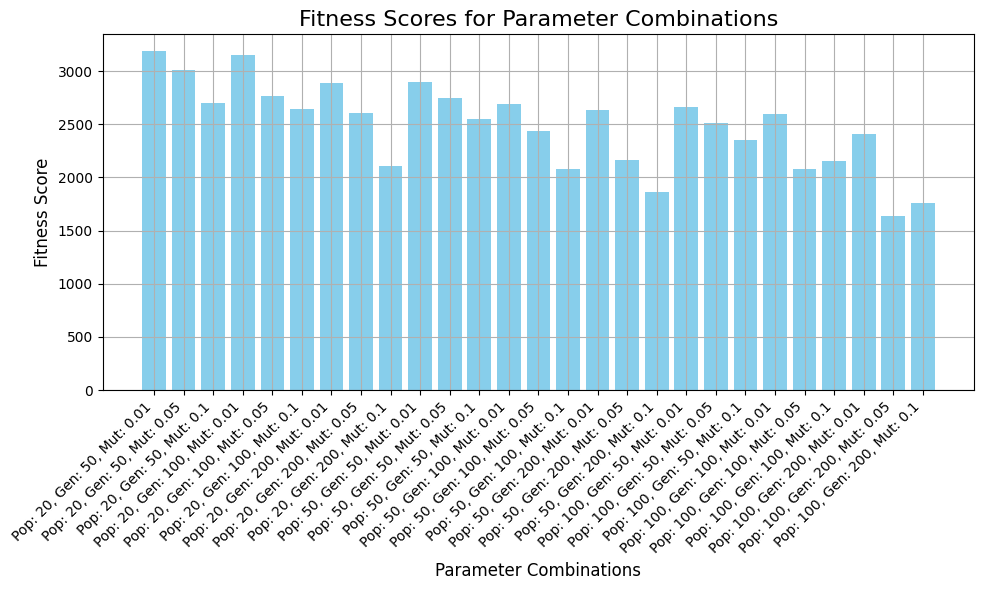

In [17]:
if __name__ == "__main__":
    root = tk.Tk()
    root.withdraw()
    file_path = "c1/c101.txt"
    if file_path:
        solve_vrptw_with_centered_depot(file_path)
        evaluate_solution(file_path)
        evaluate_parameter_combinations(file_path)

MAIN IMPLEMENTATION

Generation 1, Best Fitness: 3506.067961019428, Total Distance: 3173.062710301007
Generation 2, Best Fitness: 3361.697731446822, Total Distance: 3119.9478193639443
Generation 3, Best Fitness: 3382.616066751128, Total Distance: 3161.466607861691
Generation 4, Best Fitness: 3374.589419855586, Total Distance: 3054.087650843156
Generation 5, Best Fitness: 3323.75928255036, Total Distance: 3083.343157092894
Generation 6, Best Fitness: 3323.75928255036, Total Distance: 3083.343157092894
Generation 7, Best Fitness: 3299.8369515941936, Total Distance: 2927.39778455092
Generation 8, Best Fitness: 3209.3165458453363, Total Distance: 2934.4167154864363
Generation 9, Best Fitness: 3192.230959065436, Total Distance: 2917.3311287065353
Generation 10, Best Fitness: 3144.7332001604905, Total Distance: 2903.062780383545
Generation 11, Best Fitness: 3144.7332001604905, Total Distance: 2903.062780383545
Generation 12, Best Fitness: 3128.6157397043094, Total Distance: 2864.1842050473456
Generation 13, Best

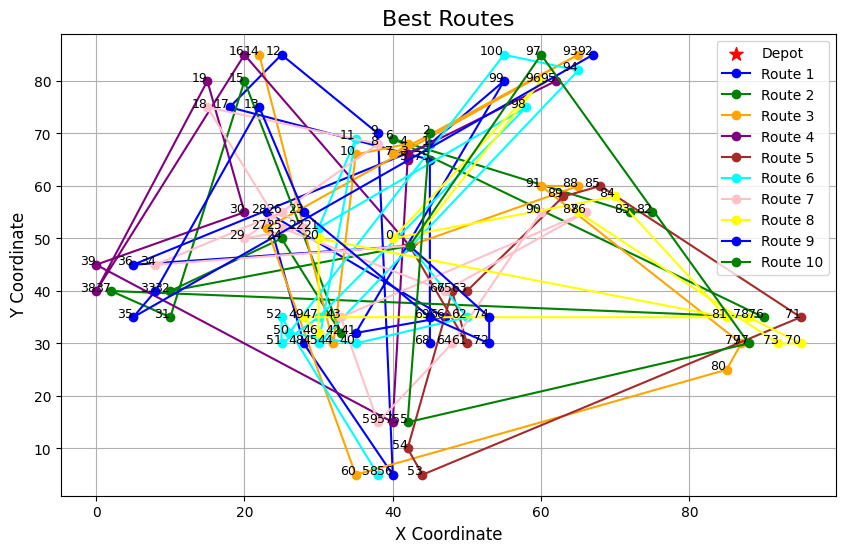

Pop: 20, Gen: 50, Mut: 0.01 => Fitness: 3502.5650844181564
Pop: 20, Gen: 50, Mut: 0.05 => Fitness: 3069.4864159660615
Pop: 20, Gen: 50, Mut: 0.1 => Fitness: 2869.1643448031245
Pop: 20, Gen: 100, Mut: 0.01 => Fitness: 3240.245873252723
Pop: 20, Gen: 100, Mut: 0.05 => Fitness: 2808.9376817319026
Pop: 20, Gen: 100, Mut: 0.1 => Fitness: 2706.7120450605416
Pop: 20, Gen: 200, Mut: 0.01 => Fitness: 3222.9554973201143
Pop: 20, Gen: 200, Mut: 0.05 => Fitness: 2549.0319471139487
Pop: 20, Gen: 200, Mut: 0.1 => Fitness: 2322.7874455429937
Pop: 50, Gen: 50, Mut: 0.01 => Fitness: 2984.1050506802358
Pop: 50, Gen: 50, Mut: 0.05 => Fitness: 2728.9550432338306
Pop: 50, Gen: 50, Mut: 0.1 => Fitness: 2832.2043966869132
Pop: 50, Gen: 100, Mut: 0.01 => Fitness: 2766.1957235571854
Pop: 50, Gen: 100, Mut: 0.05 => Fitness: 2454.1343516214347
Pop: 50, Gen: 100, Mut: 0.1 => Fitness: 2412.4556876439033
Pop: 50, Gen: 200, Mut: 0.01 => Fitness: 2472.7437313810674
Pop: 50, Gen: 200, Mut: 0.05 => Fitness: 1834.328319

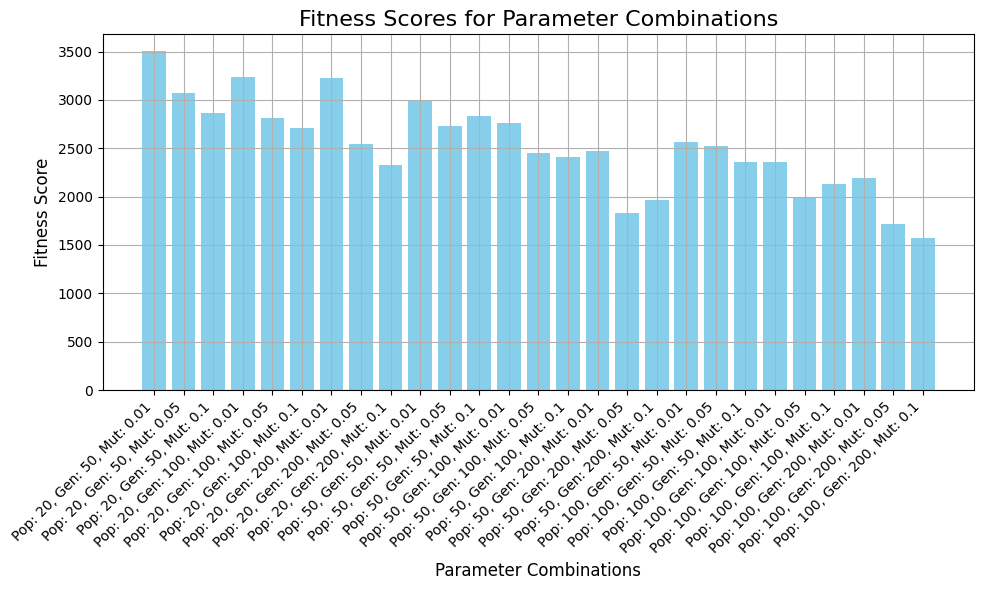

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tkinter as tk
import math
import random

def parse_input(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Initialize variables
    vehicle_capacity = None
    customers = []

    # Extract vehicle capacity by looking for the "CAPACITY" line
    for i, line in enumerate(lines):
        if "CAPACITY" in line:
            # Get the next line for the actual values
            values_line = lines[i + 1].strip().split()
            vehicle_capacity = int(values_line[1])  # Extract the capacity value
            break

    if vehicle_capacity is None:
        raise ValueError("Vehicle capacity not found in the input file.")

    # Locate the start of the customer data
    start_index = None
    for i, line in enumerate(lines):
        if "CUST NO." in line:
            start_index = i + 1  # Data starts immediately after this line
            break

    if start_index is None:
        raise ValueError("Customer data section not found in file.")

    # Parse customer data
    for line in lines[start_index:]:
        data = line.strip().split()
        if len(data) < 7:  # Ignore lines without sufficient data
            continue
        try:
            customer = {
                "id": int(data[0]),
                "x": float(data[1]),
                "y": float(data[2]),
                "demand": int(data[3]),
                "ready_time": int(data[4]),
                "due_date": int(data[5]),
                "service_time": int(data[6])
            }
            customers.append(customer)
        except ValueError:
            # Skip malformed lines
            continue

    return vehicle_capacity, customers

# Function to calculate Euclidean distance between two customers
def euclidean_distance(cust1, cust2):
    return math.sqrt((cust1['x'] - cust2['x'])**2 + (cust1['y'] - cust2['y'])**2)


# Function to calculate travel time (using Euclidean distance as a proxy for time)
def calculate_travel_time(cust1, cust2):
    return euclidean_distance(cust1, cust2)

# Function to calculate the depot's position as the center of the customer locations
def calculate_depot_center(customers):
    x_center = sum(cust['x'] for cust in customers) / len(customers)
    y_center = sum(cust['y'] for cust in customers) / len(customers)
    return x_center, y_center


# Genetic Algorithm helpers
def generate_initial_population(population_size, num_customers):
    population = []
    for _ in range(population_size):
        individual = list(range(num_customers))
        random.shuffle(individual)
        population.append(individual)
    return population


def select_parents(population, dist_matrix, vehicle_capacity, customers):
    # Tournament selection: select the best two individuals
    tournament_size = 5
    selected = random.sample(population, tournament_size)
    selected.sort(key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
    return selected[0], selected[1]

def fitness(individual, dist_matrix, vehicle_capacity, customers):
    total_distance = 0
    total_demand = 0
    num_vehicles = 1  # Start with one vehicle
    
    for i in range(len(individual) - 1):
        current_customer = customers[individual[i]]
        next_customer = customers[individual[i + 1]]
        
        total_distance += dist_matrix[individual[i]][individual[i + 1]]
        total_demand += current_customer['demand']
        
        # Check if we exceed the vehicle's capacity
        if total_demand > vehicle_capacity:
            num_vehicles += 1
            total_demand = next_customer['demand']  # Start with the next customer's demand
            
    return total_distance  # You can modify to add penalty based on vehicles used


def crossover(parent1, parent2):
    # Perform crossover between two parents (partially mapped crossover)
    size = len(parent1)
    child = [-1] * size
    crossover_point = random.randint(0, size)

    # Copy part of the first parent to the child
    for i in range(crossover_point):
        child[i] = parent1[i]

    # Fill the remaining part with genes from the second parent
    for i in range(size):
        if child[i] == -1:
            for gene in parent2:
                if gene not in child:
                    child[i] = gene
                    break
    return child

def mutate(individual, mutation_rate):
    if random.random() < mutation_rate:
        # Randomly choose two positions to swap
        pos1, pos2 = random.sample(range(len(individual)), 2)
        individual[pos1], individual[pos2] = individual[pos2], individual[pos1]
    return individual





# Constraint checking function
def check_constraints(route, customers, vehicle_capacity):
    """
    Check if the given route satisfies capacity and time window constraints.
    """
    total_demand = 0
    for customer_id in route:
        customer = customers[customer_id]
        total_demand += customer['demand']
        if total_demand > vehicle_capacity:
            return False  # Exceeds vehicle capacity
    return True

def extract_routes(solution, customers, vehicle_capacity):
    """
    Extract feasible routes from the solution and ensure they meet constraints.
    """
    routes = []
    current_route = []
    total_demand = 0

    for customer_id in solution:
        customer = customers[customer_id]
        if total_demand + customer['demand'] > vehicle_capacity:
            # Finalize the current route
            routes.append(current_route)
            current_route = []
            total_demand = 0
        current_route.append(customer_id)
        total_demand += customer['demand']

    # Append the last route
    if current_route:
        routes.append(current_route)

    # Check constraints for all routes
    feasible_routes = [route for route in routes if check_constraints(route, customers, vehicle_capacity)]
    return feasible_routes

def plot_routes(customers, best_routes, depot):
    """
    Plots all the best routes on a graph.
    """
    plt.figure(figsize=(10, 6))

    # Plot the depot (use a red star to indicate the depot)
    plt.scatter(depot[0], depot[1], c='red', marker='*', label='Depot', s=100)

    # Colors for different routes
    route_colors = ['blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'pink', 'yellow']

    # Plot each route
    for i, route in enumerate(best_routes):
        route_x = [customers[customer_id]['x'] for customer_id in route]
        route_y = [customers[customer_id]['y'] for customer_id in route]

        # Add the depot to the route for plotting the full cycle
        route_x.insert(0, depot[0])
        route_y.insert(0, depot[1])

        # Plot the route with a specific color
        plt.plot(route_x, route_y, marker='o', color=route_colors[i % len(route_colors)], label=f'Route {i + 1}')
        
        # Label customers
        for j, customer_id in enumerate(route):
            plt.text(customers[customer_id]['x'], customers[customer_id]['y'], str(customer_id), fontsize=9, ha='right')

    # Adding labels and title
    plt.title('Best Routes', fontsize=16)
    plt.xlabel('X Coordinate', fontsize=12)
    plt.ylabel('Y Coordinate', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()



# Updated main solving function
def solve_vrptw_with_centered_depot(file_path):
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    # Calculate the depot location as the center of customers
    depot_x, depot_y = calculate_depot_center(customers)
    depot = (depot_x, depot_y)

    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    population_size = 50
    generations = 100
    mutation_rate = 0.01
    population = generate_initial_population(population_size, num_customers)
    
    fitness_history = []
    best_distance = float('inf')  # Track the best distance for each generation
    best_individual_overall = None  # Track the best individual (solution) overall
    
    for gen in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))
        population = new_population

        best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
        best_fitness = fitness(best_individual, dist_matrix, vehicle_capacity, customers)
        fitness_history.append(best_fitness)

        routes = extract_routes(best_individual, customers, vehicle_capacity)
        total_distance = sum([calculate_travel_time(customers[route[i]], customers[route[i + 1]]) for route in routes for i in range(len(route) - 1)])
        
        print(f"Generation {gen + 1}, Best Fitness: {best_fitness}, Total Distance: {total_distance}")
        
        # Update the best solution found so far
        if total_distance < best_distance:
            best_distance = total_distance
            best_individual_overall = best_individual

    # Extract routes for the best overall individual
    best_routes = extract_routes(best_individual_overall, customers, vehicle_capacity)
    
    # Print the lowest distance and corresponding fitness score
    print("\nBest Overall Solution:")
    print(f"Best Total Distance: {best_distance}")
    print(f"Fitness Score: {fitness(best_individual_overall, dist_matrix, vehicle_capacity, customers)}")
    print(f"Best Routes: {best_routes}")
    
    # Display the combination of parameters
    print("\nBest Parameter Combination:")
    print(f"Population Size: {population_size}, Generations: {generations}, Mutation Rate: {mutation_rate}")


    # Plot all best routes
    plot_routes(customers, best_routes, depot)
    

def evaluate_parameter_combinations(file_path):
    # Parse input file and calculate depot location
    vehicle_capacity, customers = parse_input(file_path)
    num_customers = len(customers)

    # Calculate depot location as the center of customer locations
    depot_x, depot_y = calculate_depot_center(customers)
    depot = (depot_x, depot_y)

    # Create distance matrix
    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    # Parameter combinations
    population_sizes = [20, 50, 100]
    generations_list = [50, 100, 200]
    mutation_rates = [0.01, 0.05, 0.1]

    best_combination = None
    best_fitness = float('inf')
    results = []

    # Evaluate all combinations
    for population_size in population_sizes:
        for generations in generations_list:
            for mutation_rate in mutation_rates:
                population = generate_initial_population(population_size, num_customers)

                for gen in range(generations):
                    new_population = []
                    for _ in range(population_size // 2):
                        parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
                        child1 = crossover(parent1, parent2)
                        child2 = crossover(parent2, parent1)
                        new_population.append(mutate(child1, mutation_rate))
                        new_population.append(mutate(child2, mutation_rate))
                    population = new_population

                best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
                best_individual_fitness = fitness(best_individual, dist_matrix, vehicle_capacity, customers)

                # Record the results
                results.append({
                    'population_size': population_size,
                    'generations': generations,
                    'mutation_rate': mutation_rate,
                    'fitness': best_individual_fitness
                })

                print(f"Pop: {population_size}, Gen: {generations}, Mut: {mutation_rate} => Fitness: {best_individual_fitness}")

                # Update the best combination
                if best_individual_fitness < best_fitness:
                    best_fitness = best_individual_fitness
                    best_combination = {
                        'population_size': population_size,
                        'generations': generations,
                        'mutation_rate': mutation_rate
                    }

    print("\nBest Parameter Combination:")
    print(f"Population Size: {best_combination['population_size']}, "
          f"Generations: {best_combination['generations']}, "
          f"Mutation Rate: {best_combination['mutation_rate']}, "
          f"Fitness: {best_fitness}")
    
    # Show the best fitness score
    best_total_distance = best_fitness
    print(f"Best Total Distance Traveled: {best_total_distance}")

    # Plot results
    fitness_scores = [result['fitness'] for result in results]
    combinations = [f"Pop: {res['population_size']}, Gen: {res['generations']}, Mut: {res['mutation_rate']}" for res in results]

    plt.figure(figsize=(10, 6))
    plt.bar(combinations, fitness_scores, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title('Fitness Scores for Parameter Combinations', fontsize=16)
    plt.xlabel('Parameter Combinations', fontsize=12)
    plt.ylabel('Fitness Score', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    root = tk.Tk()
    root.withdraw()
    file_path = "c1/c101.txt"
    if file_path:
        solve_vrptw_with_centered_depot(file_path)
        evaluate_parameter_combinations(file_path)


TRIAL WITH TIME WINDOW CONSTRAINT

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Customer class to store customer details
class Customer:
    def __init__(self, customer_id, x, y, demand, ready_time, due_date, service_time):
        self.customer_id = customer_id
        self.x = x
        self.y = y
        self.demand = demand
        self.ready_time = ready_time
        self.due_date = due_date
        self.service_time = service_time

# Load customers from a file
def load_customers_from_file(file_path):
    customers = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
        # Skip the first 7 lines of the file (header info)
        for line in lines[7:]:
            if line.strip() == '':
                continue
            data = line.split()
            if len(data) < 7:
                continue  # Skip lines that do not contain enough data
            
            try:
                customer_id = int(data[0])
                x = int(data[1])
                y = int(data[2])
                demand = int(data[3])
                ready_time = int(data[4])
                due_date = int(data[5])
                service_time = int(data[6])
                
                customers.append(Customer(customer_id, x, y, demand, ready_time, due_date, service_time))
            except ValueError:
                continue  # If there's an error in converting, skip that line
    return customers

# Calculate travel time between two customers (Euclidean distance for simplicity)
def calculate_travel_time(customer1, customer2):
    return np.sqrt((customer1.x - customer2.x) ** 2 + (customer1.y - customer2.y) ** 2)

# Calculate the depot location as the center of customers
def calculate_depot_center(customers):
    avg_x = np.mean([customer.x for customer in customers])
    avg_y = np.mean([customer.y for customer in customers])
    return avg_x, avg_y

# Extract routes from the solution (a list of customer indices)
def extract_routes(solution, customers, vehicle_capacity):
    routes = []
    current_route = []
    total_demand = 0

    for customer_id in solution:
        customer = customers[customer_id]
        if total_demand + customer.demand > vehicle_capacity:
            # Finalize the current route
            routes.append(current_route)
            current_route = []
            total_demand = 0
        current_route.append(customer_id)
        total_demand += customer.demand

    # Append the last route
    if current_route:
        routes.append(current_route)

    return routes

# Fitness function: sum of distances for all routes + penalty for time window violations
def fitness(solution, dist_matrix, vehicle_capacity, customers):
    total_distance = 0
    total_demand = 0
    time_windows_violation = 0
    current_time = 0

    # Ensure that the solution is a list of routes
    routes = extract_routes(solution, customers, vehicle_capacity)
    
    for route in routes:
        for i in range(len(route) - 1):
            customer_from = customers[route[i]]
            customer_to = customers[route[i + 1]]
            
            # Time window constraints
            travel_time = dist_matrix[route[i]][route[i + 1]]
            current_time += travel_time
            
            # Arrive at customer, check if it's before the ready time
            if current_time < customer_to.ready_time:
                current_time = customer_to.ready_time
            
            if current_time > customer_to.due_date:
                time_windows_violation += 1  # Count violation
            
            current_time += customer_to.service_time
            
            total_distance += travel_time
            total_demand += customer_to.demand
    
    return total_distance + time_windows_violation * 1000  # Add a penalty for time window violations

# Crossover function for genetic algorithm
def crossover(parent1, parent2):
    # Simple ordered crossover
    size = len(parent1)
    cxpoint1 = random.randint(1, size - 2)
    cxpoint2 = random.randint(cxpoint1 + 1, size - 1)

    child = [-1] * size
    child[cxpoint1:cxpoint2] = parent1[cxpoint1:cxpoint2]

    fill_positions = [i for i in range(size) if child[i] == -1]
    parent2_idx = 0
    for pos in fill_positions:
        while parent2[parent2_idx] in child:
            parent2_idx += 1
        child[pos] = parent2[parent2_idx]

    return child

# Mutation function for genetic algorithm
def mutate(solution, mutation_rate):
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(solution)), 2)
        solution[i], solution[j] = solution[j], solution[i]
    return solution

# Generate initial population for genetic algorithm
def generate_initial_population(population_size, num_customers):
    population = []
    for _ in range(population_size):
        individual = list(range(num_customers))
        random.shuffle(individual)
        population.append(individual)
    return population

# Select parents using tournament selection
def select_parents(population, dist_matrix, vehicle_capacity, customers):
    tournament_size = 5
    selected_parents = random.sample(population, tournament_size)
    selected_parents.sort(key=lambda ind: fitness(ind, dist_matrix, vehicle_capacity, customers))
    return selected_parents[0], selected_parents[1]

# Main solving function
def solve_vrptw_with_centered_depot(file_path):
    customers = load_customers_from_file(file_path)
    vehicle_capacity = 200  # As per your example file

    num_customers = len(customers)

    # Calculate the depot location as the center of customers
    depot_x, depot_y = calculate_depot_center(customers)
    depot = (depot_x, depot_y)

    dist_matrix = np.zeros((num_customers, num_customers))
    for i in range(num_customers):
        for j in range(num_customers):
            dist_matrix[i][j] = calculate_travel_time(customers[i], customers[j])

    population_size = 100
    generations = 200
    mutation_rate = 0.
    population = generate_initial_population(population_size, num_customers)

    best_individual_overall = None
    best_distance = float('inf')

    for gen in range(generations):
        new_population = []
        for _ in range(population_size // 2):
            parent1, parent2 = select_parents(population, dist_matrix, vehicle_capacity, customers)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent2, parent1)
            new_population.append(mutate(child1, mutation_rate))
            new_population.append(mutate(child2, mutation_rate))
        population = new_population

        # Evaluate fitness of the population
        best_individual = min(population, key=lambda x: fitness(x, dist_matrix, vehicle_capacity, customers))
        best_fitness = fitness(best_individual, dist_matrix, vehicle_capacity, customers)

        # Track the best solution
        routes = extract_routes(best_individual, customers, vehicle_capacity)
        total_distance = sum([calculate_travel_time(customers[route[i]], customers[route[i + 1]]) for route in routes for i in range(len(route) - 1)])
        
        print(f"Generation {gen + 1}, Best Fitness: {best_fitness}, Total Distance: {total_distance}")

        if total_distance < best_distance:
            best_distance = total_distance
            best_individual_overall = best_individual

    # Return the best routes and the list of customers for plotting
    best_routes = extract_routes(best_individual_overall, customers, vehicle_capacity)
    
    # Check for any violations
    total_time_windows_violations = 0
    for route in best_routes:
        current_time = 0
        for i in range(len(route) - 1):
            customer_from = customers[route[i]]
            customer_to = customers[route[i + 1]]
            
            travel_time = dist_matrix[route[i]][route[i + 1]]
            current_time += travel_time
            
            if current_time < customer_to.ready_time:
                current_time = customer_to.ready_time
            
            if current_time > customer_to.due_date:
                total_time_windows_violations += 1  # Count violation

    print(f"Total time window violations: {total_time_windows_violations}")

    return best_routes, customers

if __name__ == "__main__":
    file_path = 'c1/c101.txt'  # Update the path as necessary
    best_routes, customers = solve_vrptw_with_centered_depot(file_path)

    # Plot the best routes
    plt.figure(figsize=(10, 6))






Generation 1, Best Fitness: 90517.66615263137, Total Distance: 3517.666152631374
Generation 2, Best Fitness: 90334.02732598949, Total Distance: 3334.027325989492
Generation 3, Best Fitness: 89621.78716974834, Total Distance: 3621.787169748334
Generation 4, Best Fitness: 89561.46212603107, Total Distance: 3561.4621260310614
Generation 5, Best Fitness: 89500.43493064071, Total Distance: 3500.4349306407116
Generation 6, Best Fitness: 89489.51903036857, Total Distance: 3489.5190303685636
Generation 7, Best Fitness: 89409.07765171312, Total Distance: 3409.077651713118
Generation 8, Best Fitness: 89513.85203931009, Total Distance: 3513.8520393100966
Generation 9, Best Fitness: 89406.63027618137, Total Distance: 3406.630276181373
Generation 10, Best Fitness: 89394.01416320006, Total Distance: 3394.0141632000573
Generation 11, Best Fitness: 89103.74953232628, Total Distance: 3103.7495323262806
Generation 12, Best Fitness: 89190.15700929513, Total Distance: 3190.1570092951265
Generation 13, Bes

<Figure size 1000x600 with 0 Axes>